(-0.5, 511.5, 511.5, -0.5)

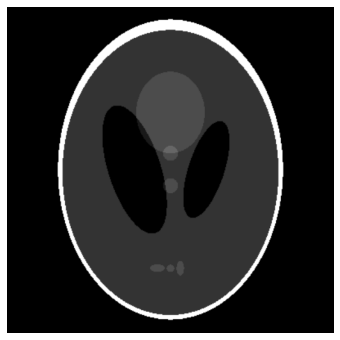

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import astra
import time

from torch_radon import Radon, RadonFanbeam
from torch_radon.solvers import cg
from torch_radon.shearlet import ShearletTransform


torch.set_grad_enabled(False)

def imshow(ax, img, title, colorbar=True, **kwargs):
    im = ax.imshow(img, **kwargs)
    if colorbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04).minorticks_on()
    ax.axis("off")
    ax.set_title(title)   

x = np.load("phantom.npy")
torch_x = torch.from_numpy(x).cuda()

plt.rcParams['figure.figsize'] = 6,6
plt.imshow(x, cmap="gray")
plt.axis("off")

Relative Error: 0.0008066455


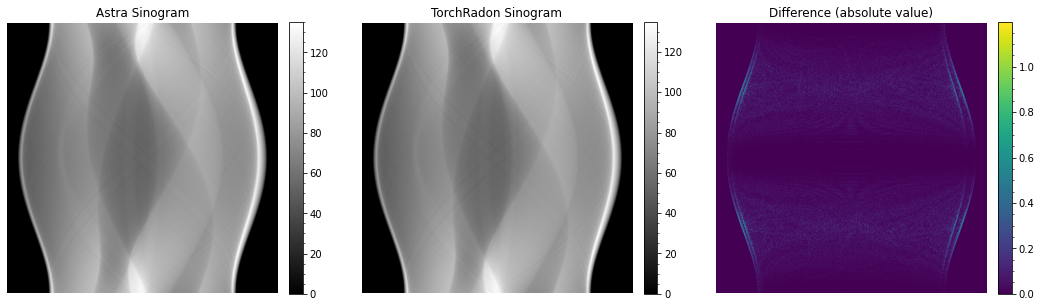

In [13]:
angles = np.linspace(0, np.pi, 512, endpoint=False)

vol_geom = astra.create_vol_geom(x.shape[0], x.shape[1])
proj_geom = astra.create_proj_geom('parallel', 1.0, x.shape[0], angles)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

radon = Radon(x.shape[0], angles)

astra_sino_id, astra_sino = astra.create_sino(x, proj_id)
tr_sino_torch = radon.forward(torch_x)
tr_sino = tr_sino_torch.detach().cpu().numpy()

diff = np.abs(astra_sino - tr_sino)
print("Relative Error:", np.linalg.norm(astra_sino - tr_sino) / np.linalg.norm(astra_sino))

plt.rcParams['figure.figsize'] = [18, 6]
fig, axs = plt.subplots(1, 3)
imshow(axs[0], astra_sino, "Astra Sinogram", cmap="gray")
imshow(axs[1], tr_sino, "TorchRadon Sinogram", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

Relative Error: 4.116853e-05


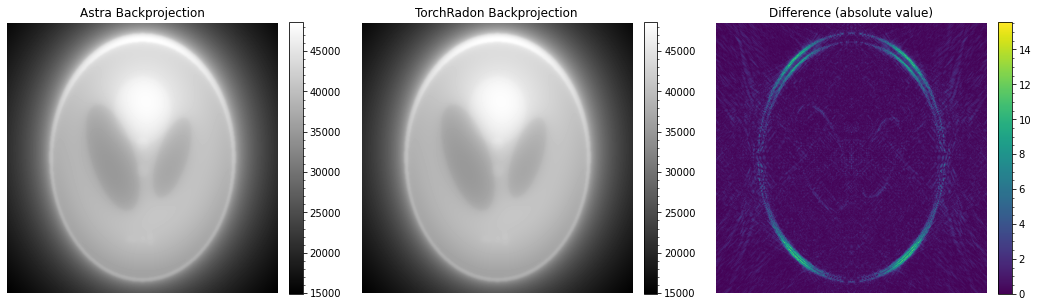

In [14]:
bp_id, bp = astra.create_backprojection(astra_sino, proj_id)
tr_bp = radon.backprojection(tr_sino_torch).detach().cpu().numpy()

print("Relative Error:", np.linalg.norm(bp - tr_bp) / np.linalg.norm(bp))
diff = np.abs(bp - tr_bp)

fig, axs = plt.subplots(1, 3)
imshow(axs[0], bp, "Astra Backprojection", cmap="gray")
imshow(axs[1], tr_bp, "TorchRadon Backprojection", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

Relative Error: 0.0008335357


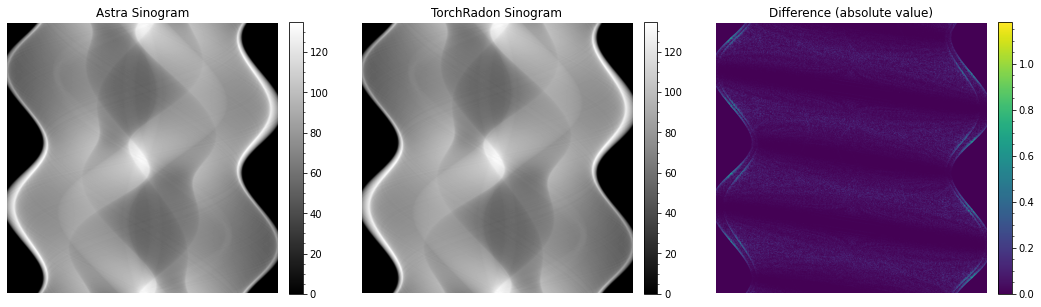

In [15]:
angles = np.linspace(0, 2*np.pi, 512, endpoint=False)

s_dist = d_dist = x.shape[0]

vol_geom = astra.create_vol_geom(x.shape[0], x.shape[1])
proj_geom = astra.create_proj_geom('fanflat', 2.0, x.shape[0], angles, s_dist, d_dist)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

radon = RadonFanbeam(x.shape[0], angles, s_dist, d_dist)

astra_sino_id, astra_sino = astra.create_sino(x, proj_id)
tr_sino_torch = radon.forward(torch_x)
tr_sino = tr_sino_torch.detach().cpu().numpy()

diff = np.abs(astra_sino - tr_sino)
print("Relative Error:", np.linalg.norm(astra_sino - tr_sino) / np.linalg.norm(astra_sino))


fig, axs = plt.subplots(1, 3)
imshow(axs[0], astra_sino, "Astra Sinogram", cmap="gray")
imshow(axs[1], tr_sino, "TorchRadon Sinogram", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

Relative Error: 4.8383223e-05


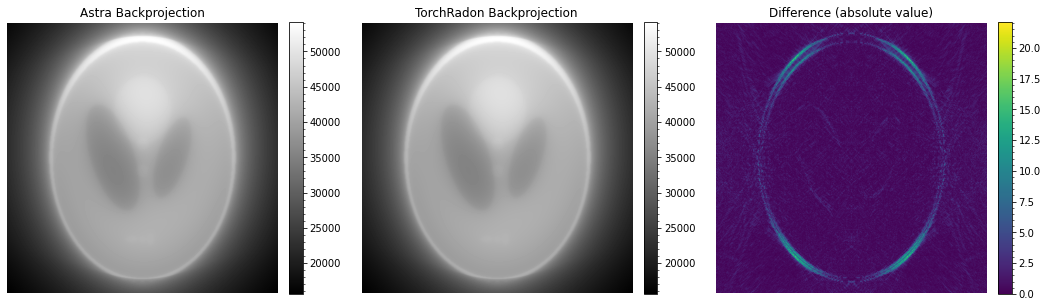

In [16]:
bp_id, bp = astra.create_backprojection(astra_sino, proj_id)
tr_bp = radon.backprojection(tr_sino_torch).detach().cpu().numpy()

print("Relative Error:", np.linalg.norm(bp - tr_bp) / np.linalg.norm(bp))
diff = np.abs(bp - tr_bp)

fig, axs = plt.subplots(1, 3)
imshow(axs[0], bp, "Astra Backprojection", cmap="gray")
imshow(axs[1], tr_bp, "TorchRadon Backprojection", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

Astra MSE: 0.00020174522
Torch Radon MSE: 0.00022222748


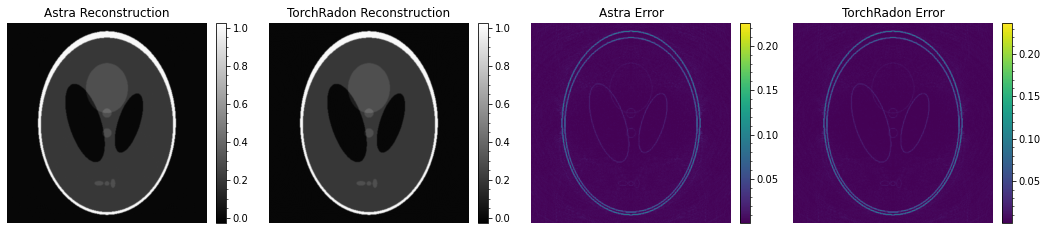

In [17]:
angles = np.linspace(0, np.pi, 512, endpoint=False)

det_count = int(np.ceil(np.sqrt(2)*x.shape[0]))

# Astra FBP
vol_geom = astra.create_vol_geom(x.shape[0], x.shape[1])
proj_geom = astra.create_proj_geom('parallel', 1.0, det_count, angles)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
astra_sino_id, astra_sino = astra.create_sino(x, proj_id)
vol_geom = astra.create_vol_geom(x.shape[0], x.shape[0])
rec_id = astra.data2d.create('-vol', vol_geom)
cfg = astra.astra_dict('FBP_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = astra_sino_id
cfg['option'] = {'FilterType': 'Ram-Lak'}
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)
fbp = astra.data2d.get(rec_id)

# TorchRadon FBP
radon = Radon(x.shape[0], angles, det_count=det_count)
sinogram = radon.forward(torch_x)
filtered_sinogram = radon.filter_sinogram(sinogram, "ram-lak")
fbp_tr = radon.backprojection(filtered_sinogram).detach().cpu().numpy()

diff = np.abs(x - fbp)
print("Astra MSE:", np.mean((x - fbp)**2))
print("Torch Radon MSE:", np.mean((x - fbp_tr)**2))


plt.rcParams['figure.figsize'] = [18, 6]
fig, axs = plt.subplots(1, 4)
imshow(axs[0], fbp, "Astra Reconstruction", cmap="gray")
imshow(axs[1], fbp_tr, "TorchRadon Reconstruction", cmap="gray")
imshow(axs[2], np.abs(x - fbp), "Astra Error")
imshow(axs[3], np.abs(x - fbp_tr), "TorchRadon Error")

# Half Precision

torch.Size([4, 512, 512])
Input Relative Error: 0.00013950403
Sinogram Relative Error: 0.0002427453
FBP MSE: 0.00020566028
FBP HP MSE: 0.00020576362


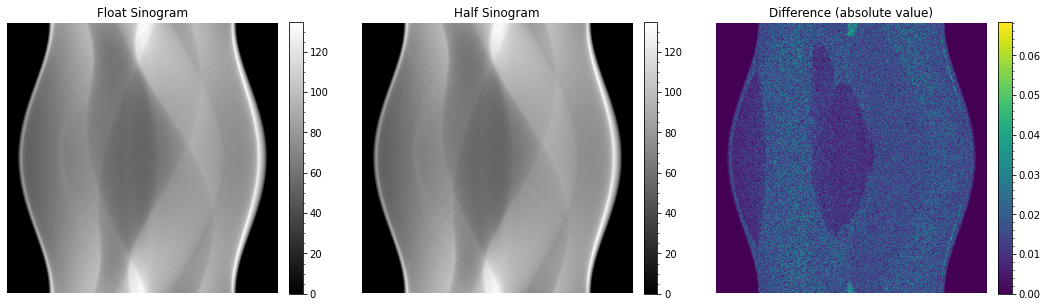

<Figure size 1296x432 with 0 Axes>

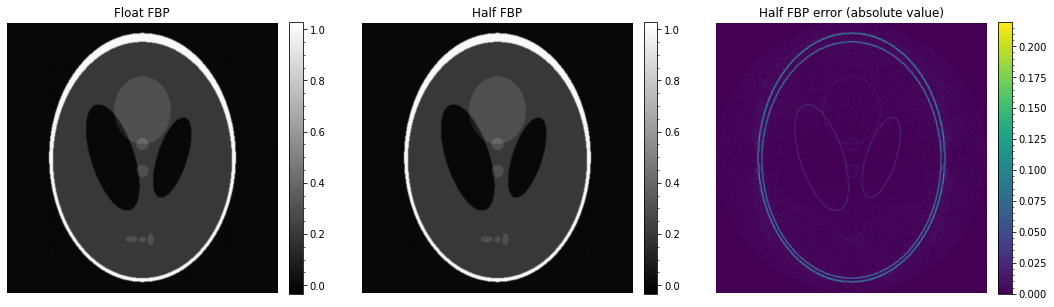

In [18]:
angles = np.linspace(0, np.pi, 512, endpoint=False).astype(np.float32)

batched_x = torch_x.view(1, x.shape[0], x.shape[1]).repeat(4, 1, 1)
batched_half = batched_x.half()
print(batched_x.size())

radon = Radon(x.shape[0], angles, clip_to_circle=True)
sinogram = radon.forward(batched_x)
sinogram_hp = radon.forward(batched_half)

fbp = radon.backprojection(radon.filter_sinogram(sinogram))[0].cpu().detach().float().numpy()
filtered_hp = radon.filter_sinogram(sinogram_hp)
fbp_hp = radon.backprojection(filtered_hp)[0].cpu().detach().float().numpy()

sino = sinogram[0].detach().cpu().numpy()
sino_hp = sinogram_hp[0].detach().cpu().float().numpy()

xx = batched_x[0].detach().cpu().numpy()
xx_half = batched_half[0].detach().cpu().float().numpy()

print("Input Relative Error:", np.linalg.norm(xx - xx_half) / np.linalg.norm(xx))
print("Sinogram Relative Error:", np.linalg.norm(sino - sino_hp) / np.linalg.norm(sino))
print("FBP MSE:", np.mean((x - fbp)**2))
print("FBP HP MSE:", np.mean((x - fbp_hp)**2))


fig, axs = plt.subplots(1, 3)
imshow(axs[0], sino, "Float Sinogram", cmap="gray")
imshow(axs[1], sino_hp, "Half Sinogram", cmap="gray")
imshow(axs[2], np.abs(sino_hp - sino), "Difference (absolute value)")

plt.figure()
fig, axs = plt.subplots(1, 3)
imshow(axs[0], fbp, "Float FBP" , cmap="gray")
imshow(axs[1], fbp_hp, "Half FBP", cmap="gray")
imshow(axs[2], np.abs(x - fbp_hp), "Half FBP error (absolute value)")

# Shearlet Transform

Precomputing shearlet system: 100%|██████████| 58/58 [00:01<00:00, 33.50it/s]


Forward Relative Error (Float): 3.8554265140474594e-07
Backward Relative Error (Float): 6.645322137246463e-07
Forward Relative Error (Double): 4.701465762506479e-16
Backward Relative Error (Double): 6.4483878308713405e-16
Alpha Reconstruction Error: 3.538386015501348e-16
TorchRadon Reconstruction Error (Float): 6.645338e-07
TorchRadon Reconstruction Error (Double): 6.136715575066494e-16


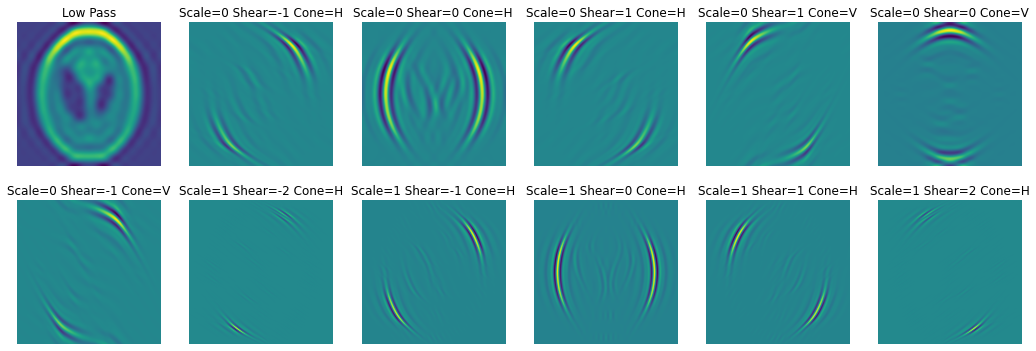

<Figure size 1296x432 with 0 Axes>

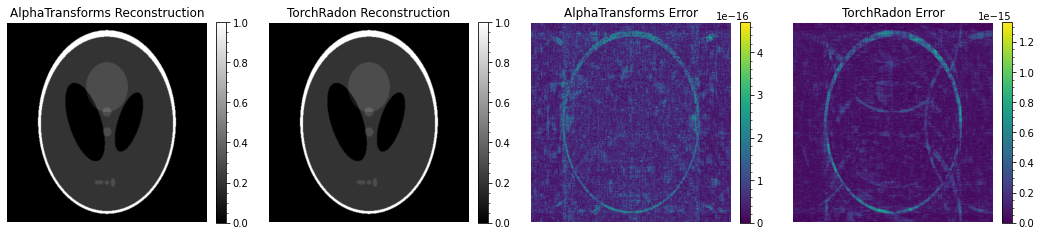

In [19]:
from alpha_transform import AlphaShearletTransform

n_scales = 5

alpha_shearlet = AlphaShearletTransform(512, 512, [0.5] * n_scales, real=True, parseval=True)
shearlet = ShearletTransform(512, 512, [0.5] * n_scales)

alpha_sh = alpha_shearlet.transform(x, do_norm=False)
sh = shearlet.forward(torch_x)
sh_double = shearlet.forward(torch_x.double())

cpu_sh = sh.detach().cpu().numpy()
cpu_sh_double = sh_double.detach().cpu().numpy()


alpha_rec = alpha_shearlet.adjoint_transform(alpha_sh, do_norm=False).real
rec = shearlet.backward(sh).detach().cpu().numpy().real
rec_double = shearlet.backward(sh_double).detach().cpu().numpy().real


print("Forward Relative Error (Float):", np.linalg.norm(alpha_sh - cpu_sh) / np.linalg.norm(alpha_sh))
print("Backward Relative Error (Float):", np.linalg.norm(alpha_rec - rec) / np.linalg.norm(alpha_rec))
print("Forward Relative Error (Double):", np.linalg.norm(alpha_sh - cpu_sh_double) / np.linalg.norm(alpha_sh))
print("Backward Relative Error (Double):", np.linalg.norm(alpha_rec - rec_double) / np.linalg.norm(alpha_rec))

print("Alpha Reconstruction Error:", np.linalg.norm(alpha_rec - x) / np.linalg.norm(x))
print("TorchRadon Reconstruction Error (Float):", np.linalg.norm(rec - x) / np.linalg.norm(x))
print("TorchRadon Reconstruction Error (Double):", np.linalg.norm(rec_double - x) / np.linalg.norm(x))

plt.rcParams['figure.figsize'] = [18, 6]
fig, axs = plt.subplots(2, 6)
ax = axs.ravel()

indices = ["Low Pass"] + [f"Scale={i[0]} Shear={i[1]} Cone={i[2].upper()}" for i in alpha_shearlet.indices[1:]]

for i in range(12):
    imshow(ax[i], sh[i].detach().cpu().numpy(), indices[i], colorbar=False)
    
plt.figure()
fig, axs = plt.subplots(1, 4)
imshow(axs[0], alpha_rec, "AlphaTransforms Reconstruction", cmap="gray")
imshow(axs[1], rec_double, "TorchRadon Reconstruction", cmap="gray")
imshow(axs[2], np.abs(x - alpha_rec), "AlphaTransforms Error")
imshow(axs[3], np.abs(x - rec_double), "TorchRadon Error")

# Iterative Reconstruction

In [60]:
from torch_radon.solvers import cg, cgne, Landweber

device = torch.device("cuda")

angles = np.linspace(0, np.pi, 512, endpoint=False)

det_count = int(np.ceil(np.sqrt(2)*x.shape[0]))
radon = Radon(x.shape[0], angles, det_count=det_count)

sinogram = radon.forward(torch_x)

landweber = Landweber(radon)

# estimate step size
alpha = landweber.estimate_alpha(512, device) * 0.95
s = time.time()
reconstruction, progress = landweber.run(torch.zeros(torch_x.size(), device=device), sinogram, alpha, iterations=500,
                                             callback=lambda xx: torch.norm(xx - torch_x).item())
print("Landweber time:", time.time() - s)

s = time.time()
cgne_rec, cgne_progress = cgne(radon, torch.zeros(torch_x.size(), device=device), sinogram, max_iter=500, callback=lambda xx: torch.norm(xx - torch_x).item())
print("CGNE time:", time.time() - s)


Landweber time: 1.5023632049560547
CGNE time: 1.613440990447998


FBP 0.00022222748
Landweber 0.000139397
CGNE 4.421942e-05


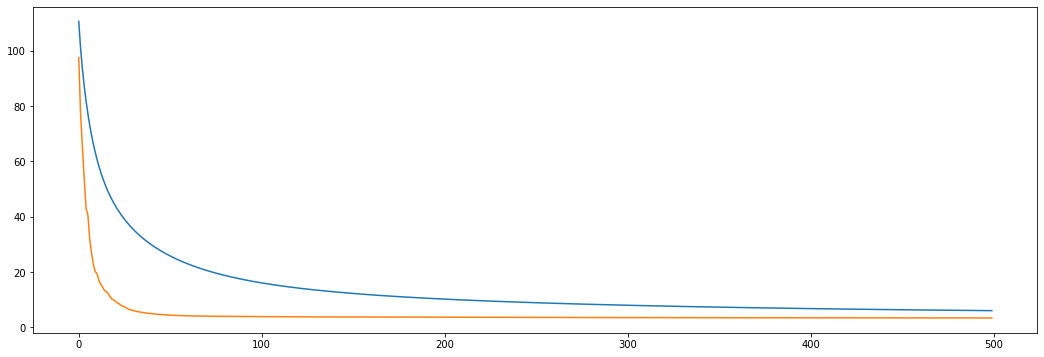

In [63]:
rec = reconstruction.detach().cpu().numpy()

plt.plot(progress)
plt.plot(cgne_progress)
# fig = plt.figure()
# fig, axs = plt.subplots(1, 2)

# imshow(axs[0], np.abs(rec-x), "", colorbar=True)
print("FBP", np.mean((fbp_tr - x)**2))
print("Landweber", np.mean((rec - x)**2))
print("CGNE", np.mean((cgne_rec.detach().cpu().numpy() - x)**2))

# Learning the Invisible

Precomputing shearlet system: 100%|██████████| 58/58 [00:02<00:00, 25.49it/s]


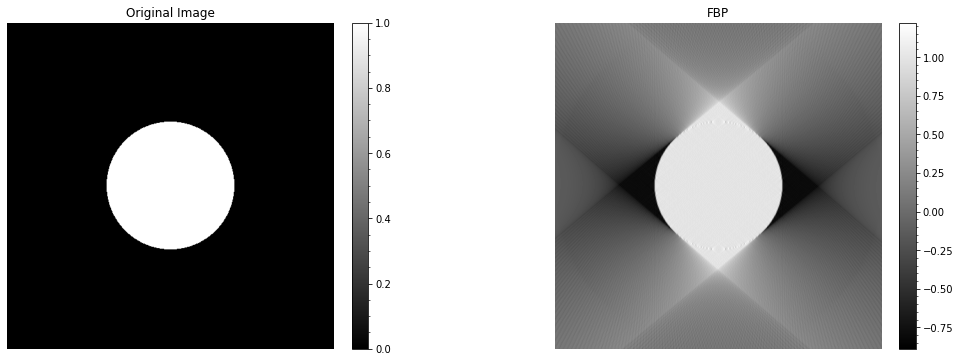

In [9]:
n_angles = 100
image_size = 512
circle_radius = 100
source_dist = 1.5*image_size
batch_size = 1
n_scales = 5

def circle_mask(size, radius):
    center = (size - 1) / 2
    c0, c1 = np.ogrid[0:size, 0:size]
    return ((c0 - center) ** 2 + (c1 - center) ** 2) <= radius ** 2

angles = (np.linspace(0., 100., n_angles, endpoint=False)-50.0) / 180.0 * np.pi

x = np.zeros((image_size, image_size), dtype=np.float32)
x[circle_mask(image_size, circle_radius)] = 1.0

radon = Radon(image_size, angles) #RadonFanbeam(image_size, angles, source_dist)
shearlet = ShearletTransform(image_size, image_size, [0.5] * n_scales)

torch_x = torch.from_numpy(x).cuda()
torch_x = torch_x.view(1, image_size, image_size).repeat(batch_size, 1, 1)
sinogram = radon.forward(torch_x)
fbp = radon.backward(radon.filter_sinogram(sinogram)).detach().cpu().numpy()

fig, axs = plt.subplots(1, 2)
imshow(axs[0], x, "Original Image", cmap="gray")
imshow(axs[1], fbp[0], "FBP", cmap="gray")
# imshow(axs[2], np.abs(sino_hp - sino), "Difference (absolute value)")


Running time: 6.322628498077393
Relative error:  9.275349229574203


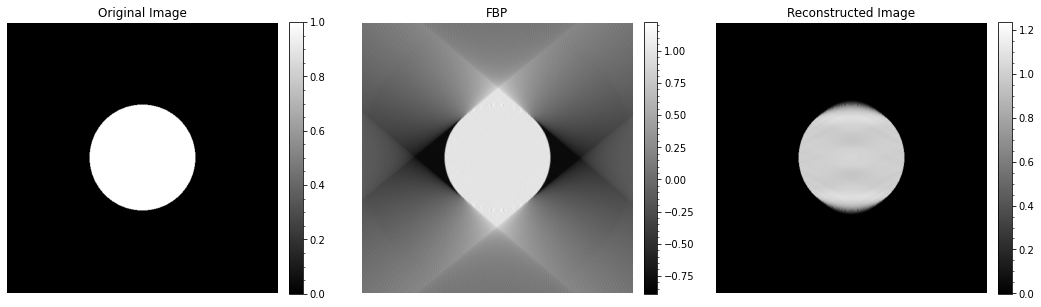

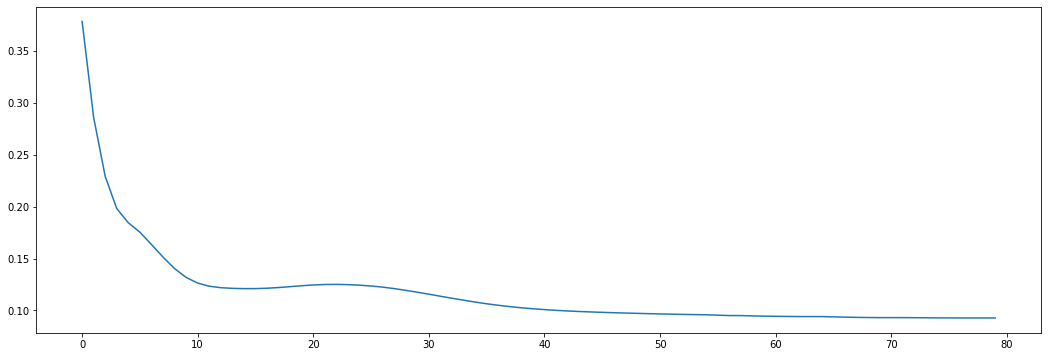

In [11]:
def shrink(a, b):
    return (torch.abs(a) - b).clamp_min(0) * torch.sign(a)


bp = radon.backward(sinogram)
sc = shearlet.forward(bp)

p_0 = 0.02
p_1 = 0.1
w = 3 ** shearlet.scales / 400
w = w.view(1, -1, 1, 1).cuda()

u_2 = torch.zeros_like(bp)
z_2 = torch.zeros_like(bp)
u_1 = torch.zeros_like(sc)
z_1 = torch.zeros_like(sc)
f = torch.zeros_like(bp)

relative_error = []
start_time = time.time()
for i in range(80):
    cg_y = p_0 * bp + p_1 * shearlet.backward(z_1 - u_1) + (z_2 - u_2)
    f = cg(lambda x: p_0 * radon.backward(radon.forward(x)) + (1 + p_1) * x, f.clone(), cg_y, max_iter=50)
    sh_f = shearlet.forward(f)

    z_1 = shrink(sh_f + u_1, p_0 / p_1 * w)
    z_2 = (f + u_2).clamp_min(0)
    u_1 = u_1 + sh_f - z_1
    u_2 = u_2 + f - z_2
    
    relative_error.append((torch.norm(torch_x[0] - f[0]) / torch.norm(torch_x[0])).item())
    
print("Running time:", time.time()-start_time)
print("Relative error: ", 100*relative_error[-1])


reconstruction = f[0].detach().cpu().numpy()
fig, axs = plt.subplots(1, 3)
imshow(axs[0], x, "Original Image", cmap="gray")
imshow(axs[1], fbp[0], "FBP", cmap="gray")
imshow(axs[2], reconstruction, "Reconstructed Image", cmap="gray")

plt.figure()
plt.plot(relative_error)